# 【顔認識】

■顔認識処理に必要なライブラリのインポート

In [68]:
import face_recognition
import dlib
import cv2
from face_recognition.api import face_distance
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image #Python Image Library
import time


■各種パラメータ設定

①検出モデル  
　hog:計算量は少ないが精度は低い  
　cnn:計算量は多いが精度は高い

In [69]:
MODEL = "hog"   
#MODEL = "cnn" 

②顔検出精度  
　number_of_times_to_upsample (1 or 2)  
　数字を大きくすると精度が上がるが計算量も上がる

In [70]:
UPSAMPLE = 2

③顔認識の閾値  
　値を低くするほど判定が厳しくなり、高くするほど判定が緩くなる。デフォルトは0.6。  
　複数の顔がある写真の認識で、ほとんどの顔が同一となった場合  
　この数値を調整することで、より精度の高い認識を行うことができる。

In [71]:
TOLERANCE = 0.6

■画像ファイル読み込み  
　image:顔認識対象の顔画像  
　unknown_image:顔認識させる画像

In [72]:
image         = cv2.imread(r"C:\photo\family_1_kid.jpg")
unknown_image = cv2.imread(r"C:\photo\family_1.jpg")

# BGR→RGBに変換
image         = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
unknown_image = cv2.cvtColor(unknown_image, cv2.COLOR_BGR2RGB)

# 時間計測(スタート)
cp_0 = time.time()

■顔認識させる画像から、「すべての顔」を検索

In [73]:
#face_recognitionライブラリのface_locationsメソッドを使用して顔を検出する
face_locations = face_recognition.face_locations(unknown_image, model=MODEL, number_of_times_to_upsample=UPSAMPLE)

# 時間計測(チェックポイント1)
cp_1 = time.time()
time_hog = cp_1 - cp_0
# 計測結果(チェックポイント1)の出力
print ("face_locations time :{0}".format(time_hog) + "[sec]", flush=True) 

face_locations time :3.675093650817871[sec]


■顔が検出できなかった場合、パラメータチューニングを実施する。

In [74]:
if len(face_locations) < 0:
    print("Face Not Found")
    print("顔を検出できませんでした。face_locationsのパラメータチューニングを行うか")
    print("顔認識させる画像を変えてみてください。")

■顔を検出できた場合、顔認識を行う

In [75]:
# 検出した顔の数を出力する。
print("I found {} face(s) in this photograph.".format(len(face_locations)))

# 比較元の顔のエリアを指定する
known_face_encodings = face_recognition.face_encodings(image)[0]
  
# 結果格納エリア
resultslist = []
distslist = []

I found 3 face(s) in this photograph.


■検出した顔の数分、認識処理を実施する。

In [76]:
for index in range(len(face_locations)):

    # 比較先の顔のエリアを指定する
    unknown_encoding = face_recognition.face_encodings(unknown_image, face_locations)[index]
    # 認識結果を出力 - True or False
    results = face_recognition.compare_faces([known_face_encodings], unknown_encoding, TOLERANCE)
    print(results)
    resultslist.append(results)

 
    # 認識値を出力 - 0 に近いと顔が似ていると判断
    dists = face_recognition.face_distance([known_face_encodings], unknown_encoding)
    print(dists)
    distslist.append(dists)



[False]
[0.74077874]
[False]
[0.61052649]
[True]
[0.07370691]


■認識処理の結果を顔認識させる画像に合成する。  
　顔は青枠で囲み、結果は白文字で表示

In [77]:

rect_color = (0, 0, 255)     # 青枠
font = cv2.FONT_HERSHEY_DUPLEX
fontsize = 0.4
font_color = (255, 255, 255) # 白
index = 0

for top, left, bottom, right in face_locations:
    # 顔を枠で囲む
    cv2.rectangle(unknown_image, (left, top), (right, bottom), rect_color, thickness=2)
    # 認識結果と値を書き込む
    cv2.rectangle(unknown_image, (right - 1, bottom), (right + 140, bottom + 20), rect_color, thickness=-1)
    cv2.putText(unknown_image, str(resultslist[index]), (right, bottom + 14), font, fontsize, font_color, 1)
    cv2.putText(unknown_image, str(distslist[index]), (right + 50, bottom + 14), font, fontsize, font_color, 1)
    index += 1


■結果をopenCVを使ってファイルに出力する。

In [78]:
output_image = cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("C:\photo\output.jpg", output_image)
cv2.imshow("image",output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

■出力された画像について  
・True／False  
　【True】 ：顔認識させる画像の中で顔認識対象としてFitした顔  
　【False】：顔認識させる画像の中で顔認識対象としてFitしなかった顔  
・数値：認識率

出力画像は「output.jpg」で保存される。

# 【課題】顔認識処理を以下の観点でカスタマイズを実施する。
**課題①**  難易度低  
顔認識結果をTrue／Falseではなく、True："SAM",False"Nobody"などとして、名前表記に変更する  
ヒント  
・「結果格納エリア」 に、「名前を格納するエリアを追加する」  
・「検出した顔の数分、認識処理を実施する。」で、「認識結果を出力」で、結果Ture/Falseにより「名前を格納するエリア」に名前を格納する。  
・「認識結果と値を書き込む」処理で、認識結果ではなく、名前を設定して表示する。(表示位置の微調整も行う)

**課題②**  難易度中  
face_recognitionで、顔をどのように分類しているか理解するために、検出した顔に特徴点を追加してみる。  
ヒント  
・「検出した顔の数分、認識処理」でface_recognitionメソッド「face_landmarks」を実行する。
・「認識処理の結果」の合成の後に、特徴点を合成する。
・特徴点合成の後、別ファイルで保存する。

 # 課題① 答え

In [79]:
#課題①処理 トータル処理
#変更箇所は★

import face_recognition
import dlib
import cv2
from face_recognition.api import face_distance
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image #Python Image Library
import time

MODEL = "hog"   
#MODEL = "cnn" 

UPSAMPLE = 2
TOLERANCE = 0.6
image         = cv2.imread(r"C:\photo\family_1_kid.jpg")
unknown_image = cv2.imread(r"C:\photo\family_1.jpg")

# BGR→RGBに変換
image         = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
unknown_image = cv2.cvtColor(unknown_image, cv2.COLOR_BGR2RGB)

# 時間計測(スタート)
cp_0 = time.time()

#face_recognitionライブラリのface_locationsメソッドを使用して顔を検出する
face_locations = face_recognition.face_locations(unknown_image, model=MODEL, number_of_times_to_upsample=UPSAMPLE)

# 時間計測(チェックポイント1)
cp_1 = time.time()
time_hog = cp_1 - cp_0
# 計測結果(チェックポイント1)の出力
print ("face_locations time :{0}".format(time_hog) + "[sec]", flush=True) 

# 検出した顔の数を出力する。
print("I found {} face(s) in this photograph.".format(len(face_locations)))

# 比較元の顔のエリアを指定する
known_face_encodings = face_recognition.face_encodings(image)[0]
  
# 結果格納エリア
resultslist = []
distslist = []
#★顔の名前保存エリア追加
namelist = []

for index in range(len(face_locations)):

    # 比較先の顔のエリアを指定する
    unknown_encoding = face_recognition.face_encodings(unknown_image, face_locations)[index]
    # 認識結果を出力 - True or False
    results = face_recognition.compare_faces([known_face_encodings], unknown_encoding, TOLERANCE)
    #print(results)
    resultslist.append(results)

    #★顔の名前設定処理 ここから
    #★初期値は"Nobody"
    name = "Nobody"
    #★認識結果が「True」の場合、namelistに追加したface_nameを設定
    #★認識結果が「False」の場合、namelistには初期値は"Nobody"を設定
    if True in results:
        name = "SAM"
    namelist.append(name)
    #★顔の名前設定処理 ここまで

 
    # 認識値を出力 - 0 に近いと顔が似ていると判断
    dists = face_recognition.face_distance([known_face_encodings], unknown_encoding)
    #print(dists)
    distslist.append(dists)

rect_color = (0, 0, 255)     # 青枠
font = cv2.FONT_HERSHEY_DUPLEX
fontsize = 0.4
font_color = (255, 255, 255) # 白
index = 0

for top, left, bottom, right in face_locations:
    # 顔を枠で囲む
    cv2.rectangle(unknown_image, (left, top), (right, bottom), rect_color, thickness=2)
    # 認識結果と値を書き込む
    cv2.rectangle(unknown_image, (right - 1, bottom), (right + 140, bottom + 20), rect_color, thickness=-1)
    #★結果を名前に変更、微調整
    #★cv2.putText(unknown_image, str(resultslist[index]), (right, bottom + 14), font, fontsize, font_color, 1)
    cv2.putText(unknown_image, str(namelist[index]), (right, bottom + 14), font, fontsize, font_color, 1)
    cv2.putText(unknown_image, str(distslist[index]), (right + 50, bottom + 14), font, fontsize, font_color, 1)
    
    index += 1

output_image = cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("C:\photo\output_name.jpg", output_image)
cv2.imshow("image",output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


face_locations time :2.1028950214385986[sec]
I found 3 face(s) in this photograph.


 # 課題② 答え

face_locations time :2.0842299461364746[sec]
I found 3 face(s) in this photograph.


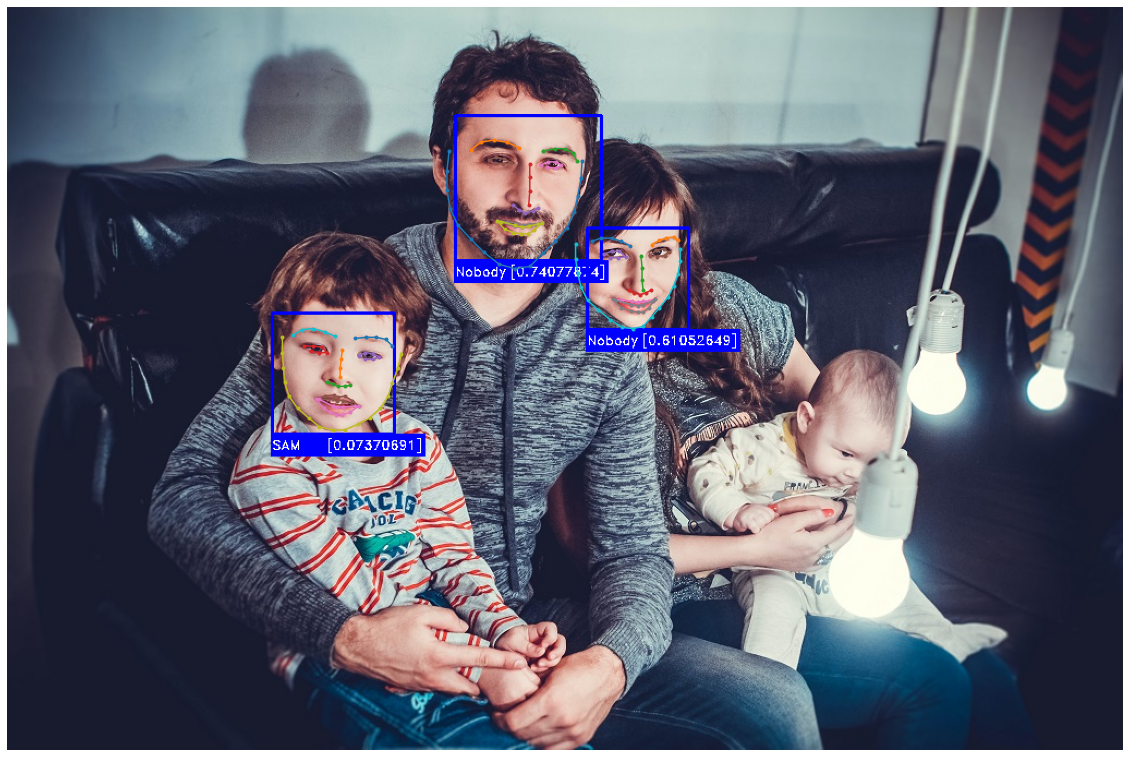

In [67]:
#課題①+②処理 トータル処理
#変更箇所は★★

import face_recognition
import dlib
import cv2
from face_recognition.api import face_distance
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image #Python Image Library
import time

MODEL = "hog"   
#MODEL = "cnn" 

UPSAMPLE = 2
TOLERANCE = 0.6
image         = cv2.imread(r"C:\photo\family_1_kid.jpg")
unknown_image = cv2.imread(r"C:\photo\family_1.jpg")

# BGR→RGBに変換
image         = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
unknown_image = cv2.cvtColor(unknown_image, cv2.COLOR_BGR2RGB)

# 時間計測(スタート)
cp_0 = time.time()

#face_recognitionライブラリのface_locationsメソッドを使用して顔を検出する
face_locations = face_recognition.face_locations(unknown_image, model=MODEL, number_of_times_to_upsample=UPSAMPLE)

# 時間計測(チェックポイント1)
cp_1 = time.time()
time_hog = cp_1 - cp_0
# 計測結果(チェックポイント1)の出力
print ("face_locations time :{0}".format(time_hog) + "[sec]", flush=True) 

# 検出した顔の数を出力する。
print("I found {} face(s) in this photograph.".format(len(face_locations)))

# 比較元の顔のエリアを指定する
known_face_encodings = face_recognition.face_encodings(image)[0]
  
# 結果格納エリア
resultslist = []
distslist = []
#★顔の名前保存エリア追加
namelist = []

for index in range(len(face_locations)):

    # 比較先の顔のエリアを指定する
    unknown_encoding = face_recognition.face_encodings(unknown_image, face_locations)[index]
    # 認識結果を出力 - True or False
    results = face_recognition.compare_faces([known_face_encodings], unknown_encoding, TOLERANCE)
    #print(results)
    resultslist.append(results)

    #★顔の名前設定処理 ここから
    #★初期値は"Nobody"
    name = "Nobody"
    #★認識結果が「True」の場合、namelistに追加したface_nameを設定
    #★認識結果が「False」の場合、namelistには初期値は"Nobody"を設定
    if True in results:
        name = "SAM"
    namelist.append(name)
    #★顔の名前設定処理 ここまで

 
    # 認識値を出力 - 0 に近いと顔が似ていると判断
    dists = face_recognition.face_distance([known_face_encodings], unknown_encoding)
    #print(dists)
    distslist.append(dists)
    
    #★★ 認識した顔の各部位を検出する
    face_landmarks = face_recognition.face_landmarks(unknown_image, face_locations)    

rect_color = (0, 0, 255)     # 青枠
font = cv2.FONT_HERSHEY_DUPLEX
fontsize = 0.4
font_color = (255, 255, 255) # 白
index = 0

for top, left, bottom, right in face_locations:
    # 顔を枠で囲む
    cv2.rectangle(unknown_image, (left, top), (right, bottom), rect_color, thickness=2)
    # 認識結果と値を書き込む
    cv2.rectangle(unknown_image, (right - 1, bottom), (right + 140, bottom + 20), rect_color, thickness=-1)
    #★結果を名前に変更、微調整
    #★cv2.putText(unknown_image, str(resultslist[index]), (right, bottom + 14), font, fontsize, font_color, 1)
    cv2.putText(unknown_image, str(namelist[index]), (right, bottom + 14), font, fontsize, font_color, 1)
    cv2.putText(unknown_image, str(distslist[index]), (right + 50, bottom + 14), font, fontsize, font_color, 1)
    
    index += 1

#★★ 顔の各部位を描画して表示 ここから
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(unknown_image)
ax.set_axis_off()

for face in face_landmarks:
    for name, points in face.items():
        points = np.array(points)
        ax.plot(points[:, 0], points[:, 1], 'o-', ms=3)
#★★ 顔の各部位を描画して表示 ここまで

#★★ 特徴点画像の保存
fig.savefig("C:\photo\output_landmarks.jpg")    
    
    
output_image = cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("C:\photo\output_name.jpg", output_image)
cv2.imshow("image",output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
